<a id="index"></a>

# Approxiamte Nearest Neighbors in Information Retrieval

Author: Guilherme K. Gomes
- guiligomes@gmail.com
- linkedin.com/in/guilherme-klein-gomes-3218b7127/
- https://github.com/GuiliGomes


"*Information retrieval (IR) is finding material (usually documents) of
an unstructured nature (usually text) that satisfies an information need
from within large collections (usually stored on computers).*"

<img src="fig/voronoi.png" style="float: right; margin:0px 30px" width="500"/>

Nearest Neighbor Search (NNS) is a fundamental building block in IR and also in various other application domains, such as pattern recognition, data mining, and recommendation
systems.

Most modern applications have massive data with high dimensionality. For those cases NNS becomes impractical and **Approximate Nearest Neighbor Search (ANNS or ANN)** takes its place.
With the advances of Representation Learning and the production of dense vectors with semantically-rich document representations, ANN gained more relevance in high scale similarity search applications.

With the advances of Representation Learning and the production of dense vectors with semantically-rich document representations, ANN gained more relevance in high scale similarity search applications.

This notebook containts an introduction guide to some of the most important ANN paradigms and algorithms:

**ANN Paradigms**:

- Local Sensitive Hash (LSH) - TODO
- Trees
- Product Quatization
- Proximity Graphs 



### Content:

- 1 [Environment Preparation](#1-Environment-Preparation)
 - 1.1 [Models](#Models)
- 2 [Sentence Embeddings](#2-Sentence-Embeddings)
- 3 [Similarity Metrics](#3-Similarity-Metrics)
 - 3.1 [Euclidian Distance](#3.1-Euclidian-Distance)
 - 3.2 [Cosine Similarity](#3.2-Cosine-Similarity)
- 4 [Document Embeddings](#4-Document-Embeddings)
- 5 [Word Movers Distance](#5-Word-Movers-Distance)
 - 5.1 [Models](#5.1-Models)
 - 5.2 [NNS with GloVe Embeddings](#5.2-NNS-with-GloVe-Embeddings)
 - 5.3 [NNS with Bert Embeddings](#5.3-NNS-with-Bert-Embeddings)
- 6 [ANN - Aproximate Nearest Neighbors](#6-ANN---Aproximate-Nearest-Neighbors)
- 7 [ANNOY - Approximate Nearest Neighbor Oh Yeah](#7-ANNOY---Approximate-Nearest-Neighbor-Oh-Yeah)
- 8 [Product Quantizers Methods](#8-Product-Quantizers-Methods)
 - 8.1 [Vector Quantization](#8.1-Vector-Quantization)
 - 8.2 [Product Quantizers](#8.2-Product-Quantizers)
 - 8.3 [FAISS](#8.3-FAISS)
- 9 [Small World Graphs](#9-Small-World-Graphs)
 - 9.1 [HNSW](#9.1-HNSW)


In [1]:
# std libs
from collections import Counter
from typing import List, Tuple, Dict
import sys
import math
import random
import pickle

# 3rd party
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ml
from scipy.spatial.distance import cdist
import torch
from transformers import AutoTokenizer, AutoModel
import spacy
from wmd import WMD
from annoy import AnnoyIndex
import faiss
import hnswlib

# local
from utils.plots import plot_embedding_groups, plot_embedding_groups_3d

## 1 Environment Preparation

### 1.1 Models

In [2]:
nlp = spacy.load("en_core_web_md")

In [3]:
embed_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
embed_model = AutoModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 1.2 Functions

In [4]:
def get_sentence_embedding(sentence: str) -> np.ndarray:
    encoded_input = embed_tokenizer(sentence, return_tensors='pt')
    embeddings = embed_model.embeddings(encoded_input['input_ids'])
    return embeddings.squeeze(0).mean(dim=0).detach().numpy()

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def apply_pca(M, k=2):
    pca = PCA(n_components=k, random_state=34)
    M_reduced = pca.fit_transform(M)
    return M_reduced

def apply_tsne(M, k=2, svd_solver='exact', pp = 30.0):
    M_reduced = TSNE(n_components=k, perplexity=pp, learning_rate=500, random_state=34).fit_transform(M)
    return M_reduced

In [6]:
def prepare_plot_data(ids, sentences, embeddings):
    
    # xy = apply_tsne(embeddings, pp=5.0)
    # xyz = apply_tsne(embeddings, k=3, pp=50.0)
    xy = apply_pca(embeddings)
    xyz = apply_pca(embeddings, k=3)
    
    dict_to_plot = {}
    for idx, item in enumerate(zip(ids, sentences, xy, xyz)):
        sentence_id = item[0]
        sentence = item[1]
        xy_ = item[2]
        xyz_ = item[3]
        if not sentence_id in dict_to_plot.keys():
            dict_to_plot[sentence_id] = {}
            dict_to_plot[sentence_id]['sentences'] = [sentence]
            dict_to_plot[sentence_id]['xy'] = [xy_]
            dict_to_plot[sentence_id]['xyz'] = [xyz_]
        else:
            dict_to_plot[sentence_id]['sentences'].append(sentence)
            dict_to_plot[sentence_id]['xy'].append(xy_)
            dict_to_plot[sentence_id]['xyz'].append(xyz_)
    return dict_to_plot

In [7]:
def print_knn(rank: int, documents: list, doc_idx: int, big_text = True) -> str:
    if big_text:
        print('-'*40)
        print(f"Rank {rank} Document: {documents[doc_idx][0]}")
        print('Text Snip:')
        print(documents[doc_idx-1][1] + ' ' + documents[doc_idx][1] + ' ' + documents[doc_idx+1][1])
        print('-'*40)
    else:
        print('-'*40)
        print(f"Rank {rank} Document: {documents[doc_idx][0]}")
        print(documents[doc_idx][1])
        print('-'*40)


## 2 Sentence Embeddings
[Back to Top](#index)

In [8]:
sentences = [
    "I like rock'n'roll",
    "They listen to music",
    "Chuck Berry has an american musican",
    "She can hear some melody",
    
    "We need the vaccine",
    "Many people are sick",
    "A new virus is causing the pandemic",
    "Now we have the vaccine",
    
    "I like mother nature",
    "Summer is cool",
    "We need to protect the ocean"
]
colors = ['blueviolet', 'orange', 'turquoise']

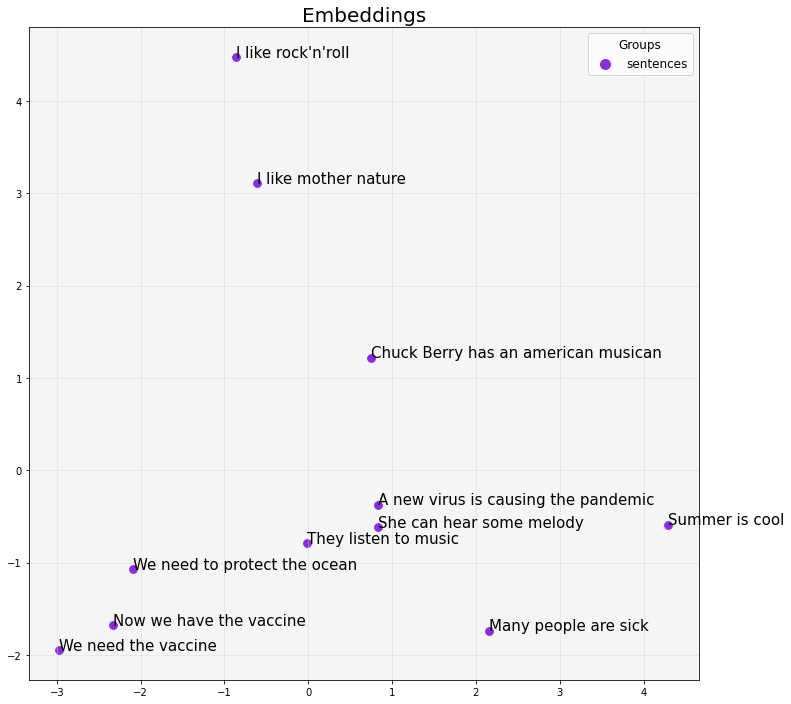

In [9]:
ids = ['sentences']*len(sentences)
embeddings = np.array([get_sentence_embedding(sent) for sent in sentences])
plot_data = prepare_plot_data(ids, sentences, embeddings)
plot_embedding_groups(plot_data, colors=colors)

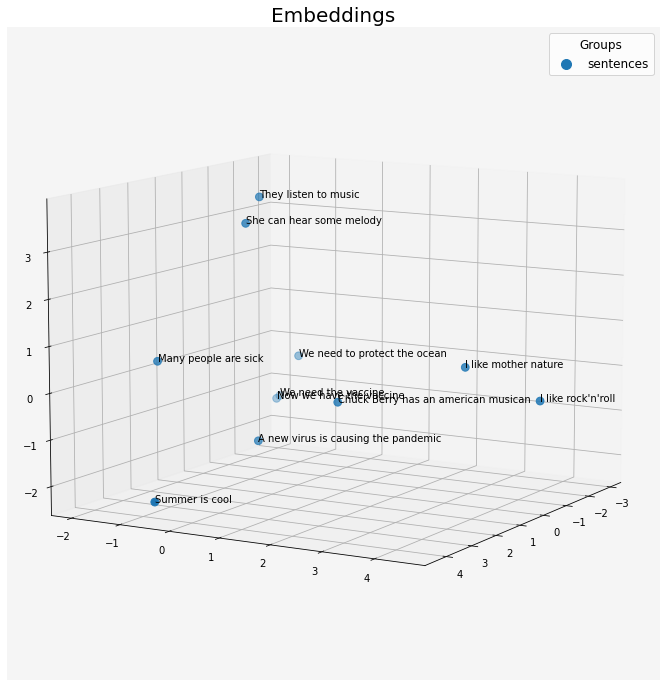

In [10]:
plot_embedding_groups_3d(plot_data, angles=(10,30))

### 2.1 Adding a Query

In [11]:
query = 'I love surfboarding'

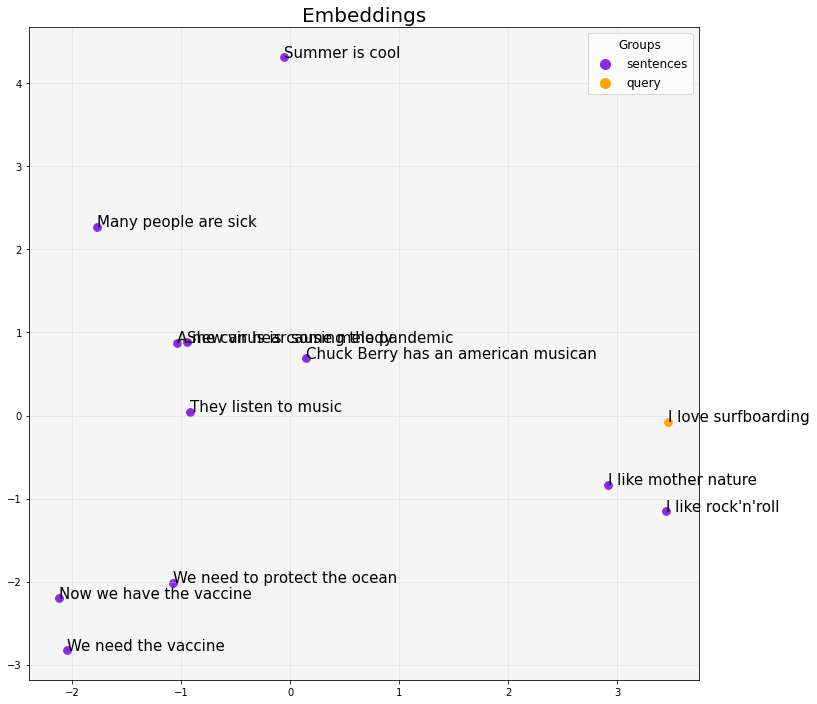

In [12]:
# rebuild sentence list with the query
ids = ['sentences']*len(sentences) + ['query']
sentences_with_query = sentences + [query]
embeddings_with_query = np.array([get_sentence_embedding(sent) for sent in sentences_with_query])

plot_data = prepare_plot_data(ids, sentences_with_query, embeddings_with_query)
plot_embedding_groups(plot_data, colors=colors)

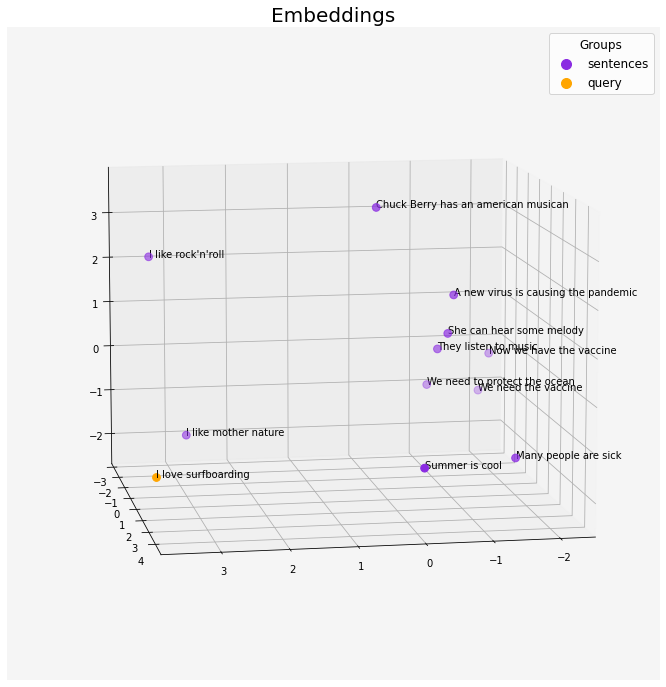

In [13]:
plot_embedding_groups_3d(plot_data, colors=colors, angles=(10, 80))

<img src="gif/sentence_query.gif"/>

## 3 Similarity Metrics
[Back to Top](#index)

### 3.1 Euclidian Distance
In mathematics, the Euclidean (or Euclidian Norm) distance between two points in Euclidean space is the length of a line segment between the two points. It can be calculated from the Cartesian coordinates of the points using the Pythagorean theorem, therefore occasionally being called the Pythagorean distance.
When viewing Euclidean space as a vector space, its distance is associated with a norm called the Euclidean norm, defined as the distance of each vector from the origin. One of the important properties of this norm, relative to other norms, is that it remains unchanged under arbitrary rotations of space around the origin.
On the $n$-dimensional Euclidean space ${\displaystyle \mathbb {R} ^{n}}$, the intuitive notion of a distance between vectors $p$ and $q$ is captured by the formula:

$$
{\parallel}p-q{\parallel}_{2} := \sqrt{\sum_{i=1}^{n}{(p_{i}-q_{i})^{2}}}
$$

For neighbors search, it is possible to ommit the square root, since it is monotonically increasing function. Thi is called the L2-Squared norm:

$$
{\parallel}p-q{\parallel}_{2}^{2} := \sum_{i=1}^{n}{(p_{i}-q_{i})^{2}}
$$

Here we compute euclidian distance using [SciPy](https://www.scipy.org/) [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html):

In [14]:
THRESHOLD = 7.5
distances = cdist([get_sentence_embedding(query)], embeddings, metric='euclidean')
distances = distances[0]
below_threshold_mask = distances < THRESHOLD
below_threshold_indexes = np.where(below_threshold_mask)[0]

print(f"Query: {query}")
result = []
for idx in below_threshold_indexes:
    result.append((sentences[idx], distances[idx]))
result = sorted(result, key=lambda x: x[1])
result

Query: I love surfboarding


[('We need to protect the ocean', 7.2700892037012155),
 ('I like mother nature', 7.409277405922192)]

We can also calculate it from scratch:

In [15]:
q_embed = get_sentence_embedding(query)
test_embed = embeddings[len(embeddings)-1]

sum_ = 0.0
for idx in range(q_embed.shape[0]):
    sum_ += (q_embed[idx] - test_embed[idx]) ** 2

distance = math.sqrt(sum_)

print(f"Query: {query}")
print(f'Distance: {distance}')

Query: I love surfboarding
Distance: 7.270089193714386


## 3.2 Cosine Similarity
Cosine similarity is a measure of similarity between two non-zero vectors $p$ and $q$ of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

$$
similarity =
cos(\theta) =
\frac{p{\cdot}q}{{\parallel}p{\parallel\parallel}q{\parallel}} =
\frac{\sum_{i=1}^{n} p_{i} q_{i}}{\sqrt{\sum_{i=1}^{n} p_{i}^{2}}\sqrt{\sum_{i=1}^{n} q_{i}^{2}}}
$$

Here we compute cossine distance using scipy [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html):

In [16]:
THRESHOLD = 0.5

In [17]:
distances = cdist([get_sentence_embedding(query)], embeddings, metric='cosine')
distances = distances[0]
below_threshold_mask = distances < THRESHOLD
below_threshold_indexes = np.where(below_threshold_mask)[0]

result = []
for idx in below_threshold_indexes:
    result.append((sentences[idx], distances[idx]))
result = sorted(result, key=lambda x: x[1])
result

[('I like mother nature', 0.4681082333604596),
 ('We need to protect the ocean', 0.485726817009154)]

## 4 Document Embeddings
[Back to Top](#index)

In [18]:
titles = [
    "Bob Marley",
    "Peter Tosh",
    "Reggae",
    "Cancer",
    "Heineken",
    "UEFA Champions League",
    "Star Wars",
    "Olympic Games",
    "Brazil",
    "Argentina",
    "Portugal",
    "Star Trek"
]

In [19]:
documents = []
nbow = {}
for title in titles:
    print(f"fetching {title}")
    pages = requests.get(
        "https://en.wikipedia.org/w/api.php?action=query&format=json&titles=%s"
        "&prop=extracts&explaintext" % title).json()["query"]["pages"]
    
    print(f"parsing {title}")
    text_str = next(iter(pages.values()))["extract"]
    sentences = text_str.replace('...', '.').split('.')
    sentences = [sent.strip() + '.' for sent in sentences]
    sentence_embeddings = np.array([get_sentence_embedding(sent) for sent in sentences])
    text_nlp = nlp(text_str)
    tokens = [t for t in text_nlp if t.is_alpha and not t.is_stop]
    words = Counter(t.text for t in tokens)
    orths = {t.text: t.orth for t in tokens}
    sorted_words = sorted(words)
    documents.append((title, sentences[0][0:50] + "...", sentence_embeddings.mean(axis=0), sentence_embeddings, sentences))
    nbow[title] = (title, [orths[t] for t in sorted_words],
                        np.array([words[t] for t in sorted_words], dtype=np.float32))
    print(f"Total Sentences for {title}: {len(sentences)}")

flat_embed = np.array([embed for row in documents for embed in row[3]])
flat_text = [(row[0], sent) for row in documents for sent in row[4]]
print(f'Total sentences: {len(flat_embed)}')


fetching Bob Marley
parsing Bob Marley
Total Sentences for Bob Marley: 224
fetching Peter Tosh
parsing Peter Tosh
Total Sentences for Peter Tosh: 99
fetching Reggae
parsing Reggae
Total Sentences for Reggae: 441
fetching Cancer
parsing Cancer
Total Sentences for Cancer: 546
fetching Heineken
parsing Heineken
Total Sentences for Heineken: 48
fetching UEFA Champions League
parsing UEFA Champions League
Total Sentences for UEFA Champions League: 172
fetching Star Wars
parsing Star Wars
Total Sentences for Star Wars: 331
fetching Olympic Games
parsing Olympic Games
Total Sentences for Olympic Games: 540
fetching Brazil
parsing Brazil
Total Sentences for Brazil: 664
fetching Argentina
parsing Argentina
Total Sentences for Argentina: 647
fetching Portugal
parsing Portugal
Total Sentences for Portugal: 965
fetching Star Trek
parsing Star Trek
Total Sentences for Star Trek: 443
Total sentences: 5120


In [20]:
embeddings = [doc[2] for doc in documents]
ids = [doc[0] for doc in documents]
sentences = [doc[1] for doc in documents]
plot_data = prepare_plot_data(ids, sentences, embeddings)

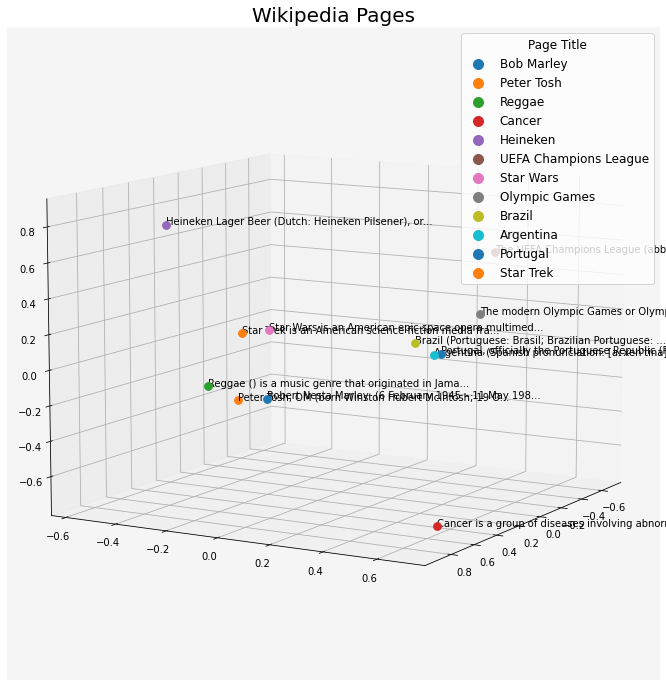

In [21]:
plot_embedding_groups_3d(plot_data,
                         title="Wikipedia Pages",
                         legend_title="Page Title",
                         angles=(10,30))

# plot_embedding_groups_3d(plot_data,
#                          title="Wikipedia Pages",
#                          legend_title="Page Title",
#                          angles=(10,30),
#                          save_gif_dir='gif')

<img src="gif/wiki1.gif" />

## 5 Word Movers Distance
[Back to Top](#index)

<img src="fig/wmd1.png" style="float: right;" alt="drawing" width="400"/>
Word Mover’s Distance (WMD) is proposed for distance measurement between 2 documents (or sentences), leveraging that times novelty of Word Embeddings like Word2Vec. They proposed to use word embeddings to calculate the similarities appliyng normalized Bag-of-Words and the representations to calculate the distance between documents. The method has no hyperprameters.

References:
- [Word Mover's Distance](http://www.cs.cornell.edu/~kilian/papers/wmd_metric.pdf)
- [WMD Relax](https://github.com/src-d/wmd-relax)

### 5.1 Models

In [22]:
class SpacyEmbeddings(object):
    def __getitem__(self, item):
        return nlp.vocab[item].vector

class BertEmbeddings(object):
    def __getitem__(self, item):
        return get_sentence_embedding(nlp.vocab[item].text)

### 5.2 NNS with GloVe Embeddings

In [23]:
# hook in WMD
calc = WMD(SpacyEmbeddings(), nbow)
print(f"Query: {titles[0]} Page")
print("Calculating similar pages:")
for title, relevance in calc.nearest_neighbors(titles[0]):
    print("%24s\t%s" % (title, relevance))

Query: Bob Marley Page
Calculating similar pages:
              Peter Tosh	3.953218460083008
                  Reggae	4.88713264465332
               Argentina	5.882890701293945
               Star Trek	6.0543622970581055
           Olympic Games	6.063663959503174
                  Brazil	6.072596549987793
                Portugal	6.098607063293457
               Star Wars	6.1729655265808105
   UEFA Champions League	6.239352703094482
                Heineken	6.354133129119873


### 5.3 NNS with Bert Embeddings

In [24]:
# hook in WMD
calc_bert = WMD(BertEmbeddings(), nbow)
print(f"Query: {titles[0]} Page")
print("Calculating similar pages:")
for title, relevance in calc_bert.nearest_neighbors(titles[0],k=30):
    print("%24s\t%s" % (title, relevance))

Query: Bob Marley Page
Calculating similar pages:
              Peter Tosh	4.784566879272461
                  Reggae	5.386720180511475
               Argentina	6.514484405517578
           Olympic Games	6.5948591232299805
                  Brazil	6.596113681793213
               Star Trek	6.602570533752441
                Portugal	6.62761926651001
               Star Wars	6.683468341827393
   UEFA Champions League	6.856717586517334
                  Cancer	6.863679885864258
                Heineken	7.053093433380127


## 6 ANN - Aproximate Nearest Neighbors
[Back to Top](#index)

In some applications it may be acceptable to retrieve a "good guess" of the nearest neighbor. In those cases, we can use an algorithm which doesn't guarantee to return the actual nearest neighbor in every case, in return for improved speed or memory savings. Often such an algorithm will find the nearest neighbor in a majority of cases, but this depends strongly on the dataset being queried.
<img src="fig/ann_benchmark.png" style="float:right; margin:0px 20px" alt="drawing" width="600" padding="0" />
An approximate nearest neighbor (ANN) search algorithm is allowed to return points, whose distance from the query is at most $c$ times the distance from the query to its nearest points. The appeal of this approach is that, in many cases, an approximate nearest neighbor is almost as good as the exact one. In particular, if the distance measure accurately captures the notion of user quality, then small differences in the distance should not matter

ANN algorithms are typically compared based on the trade-off between search quality and efficiency. A baseline could be the naive k neareast neighborhood search (k-NN), which is inherently expensive due to the curse of dimensionality:

$$
O(k * n * d)
$$

where $k$ is the number of results, $n$ is the number of data points to be searched and $d$ is the number of dimensions.
Some examples of algorithms that support the approximate nearest neighbor search are:

- [Approximate Nearest Neighbors Oh Yeah - ANNOY:](https://github.com/spotify/annoy) Used it at Spotify for music recommendations.

References:
- [ANN Benchmarks](http://ann-benchmarks.com/index.html)
- [Product Quantization for Nearest Neighbor Search](https://lear.inrialpes.fr/pubs/2011/JDS11/jegou_searching_with_quantization.pdf)



## 7 ANNOY - Approximate Nearest Neighbor Oh Yeah
[Back to Top](#index)

<img src="fig/ann-tree-full-K-1024x793.png" style="float:right; margin:0px 20px" alt="drawing" width="600" padding="0" /><i>"We use it at Spotify for music recommendations. After running matrix factorization algorithms, every user/item can be represented as a vector in f-dimensional space. This library helps us search for similar users/items. We have many millions of tracks in a high-dimensional space, so memory usage is a prime concern."</i>

Using random projections and by building up a tree. At every intermediate node in the tree, a random hyperplane is chosen, which divides the space into two subspaces. This hyperplane is chosen by sampling two points from the subset and taking the hyperplane equidistant from them.

**References:**
- [github.com/spotify/annoy](https://github.com/spotify/annoy)
- [Nearest neighbors and vector models – part 2 – algorithms and data structures](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html)


### 7.1 Index Creation

In [26]:
n = len(flat_embed)
f = len(flat_embed[0])
n_trees = 10
output_index_file = 'indexes/demo.annoy'

t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(n):
    t.add_item(i, flat_embed[i])

t.build(n_trees)
t.save(output_index_file)

True

### 7.2 Index Load

In [27]:
u = AnnoyIndex(f, 'angular')
u.load(output_index_file) # super fast, will just mmap the file

True

### 7.3 Query

In [28]:
query_index = 232
query = flat_text[query_index]
print(query)

('Peter Tosh', 'He then picked up the guitar and played the song back to the man.')


In [29]:
%timeit u.get_nns_by_item(query_index, 3) # will find the 1000 nearest neighbors
neighbors = u.get_nns_by_item(query_index, 3) # will find the 1000 nearest neighbors

50.6 µs ± 625 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
print('-'*40)
print('Query:')
print(query)
print('Results:')
print('-'*40)

for rank, idx in enumerate(neighbors):
    print_knn(rank+1, flat_text, idx)
#     print(f"Document Rank {rank}: {flat_text[idx][0]}")
#     print(f"Sentence {flat_text[idx][1]}")
#     print('-'*40)


----------------------------------------
Query:
('Peter Tosh', 'He then picked up the guitar and played the song back to the man.')
Results:
----------------------------------------
----------------------------------------
Rank 1 Document: Peter Tosh
Text Snip:
He watched the man play the same song for half a day, memorizing everything his fingers were doing. He then picked up the guitar and played the song back to the man. The man then asked McIntosh who had taught him to play; McIntosh told him that he had.
----------------------------------------
----------------------------------------
Rank 2 Document: Peter Tosh
Text Snip:
Through his contact with Higgs, Tosh met Robert Nesta Marley (Bob Marley) and Neville O'Reilly Livingston (Bunny Wailer). He then changed his name to Peter Tosh and the trio started singing together in 1962. Higgs taught the trio to harmonize and while developing their music, they would often play on the street corners of Trenchtown.
----------------------------

## 8 Product Quantizers Methods
[Back to Top](#index)


### 8.1 Vector Quantization
Quantization is a destructive process with the purpose to reduce the cardinality of the representation space, in particular when the input data is real-valued.
Formally, a quantizer is a function $q$ mapping a $D$-dimensional vector $x\in\mathbb{R}^{D}$ to a vector $q(x)\in\mathcal{C}=\{c_{i};i\in\mathcal{I}\}$, where the index set $\mathcal{I}$ is assumed to be finite: $\mathcal{I} = 0 \dots k - 1$. The reproduction values $c_{i}$ are called *centroids*, and the set of these reproduction values $\mathcal{C}$ is called *codebook* of size $k$.
The set $\mathcal{V_{i}}$ of vectors mapped to a given index centroid $c_{i}$ is referred to as a *cell* (also known as Voronoi Cell), and defined as:

$$
\mathcal{V_{i}} \triangleq \{x\in\mathbb{R}^{D}:q(x)=c_{i}\}
$$

By definition, all the vectors lying in the same cell $\mathcal{V_{i}}$ are reconstructed by the same centroid $c_{i}$.

#### 8.1.1 Quantizer Quality

The quality of a quantizer is usually measured by the mean squared error between the input vector $x$ and its reproduction value $q(x)$:

$$
\mathrm{MSE(q)} = \mathbb{E}_{X} \left[d(q(x),x))^{2}\right] = {\int}p(x)\,d\left(q(x),x\right)^{2}\, dx
$$

where $d(x; y) = {\parallel x-y \parallel}$ is the Euclidean distance between $x$ and $y$, and $p(x)$ is the probability distribution function corresponding the random variable $X$. For an arbitrary probability distribution function, this is numerically computed using Monte-Carlosampling, as the average of $\parallel q(x) - x \parallel$ on a large set of samples.

#### 8.1.2 Lloyd Optimality Conditions

In order for the quantizer to be optimal, it has to satisfy two properties known as the *Lloyd optimality conditions*. First, a vector $x$ must be quantized to its nearest codebook centroid, in terms of the Euclidean distance:

$$
q(x) = {\underset{c_{i}\in\mathcal{C}}{\mathrm{argmin}}\, d(x,c_{i})}
$$

As a result, the cells are delimited by hyperplanes. The second Lloyd condition is that the reconstruction value must be the expectation of the vectors lying in the Voronoi Cell:

$$
c_{i} = \mathbb{E}_{X}[x|i] = {\int\limits_{V_{i}}}p(x)\,x\,dx
$$

### 8.2 Product Quantizers

Let's consider a scenario where we need to work with vectors of 128 dimensions. Assuming we accept a 64-bit quantizer, which means "*half of a bit*" per dimension, this quantizer will have $k = 2^{64}$ centroids. Therefore, it is impossible to use Lloyd’s algorithm as the number of samples required and the complexity of learning the quantizer are several times $k$. It is even impossible to store the $D\,{\times}\,k$ floating point values representing the $k$ centroids.

**Product quantization** is an efficient solution to address these issues.

The input vector $x$ is split into $m$ distinct subvectors $u_{j}, 1 \leq j \leq m$ of dimension $D^{*} = D/m$, where $D$ is a multiple of $m$. The subvectors are quantized separately using $m$ distinct quantizers. A given vector $x$ is therefore mapped as follows:

$$
\underset{u_{1}(x)}{x_{1},\dots x_{D^{*}}},\dots,\underset{u_{m}(x)}{x_{D-D^{*}+1},\dots x_{D}} \to q_{1}\left(u_{1}(x)\right),\dots,q_{m}\left(u_{m}(x)\right)
$$

where $q_{j}$ is a low-complexity quantizer associated with the $j^{th}$ subvector. With the subquantizer $q_{j}$ we associate the index set $\mathcal{I}_{j}$ , the codebook $\mathcal{C}_{j}$ and the corresponding reproduction values $c_{j,i}$.

A reproduction value of the product quantizer is defiend by an element of the index set

$$
\mathcal{I} = \mathcal{I}_{1} \times\ldots\times\mathcal{I}_{m}
$$

... and finally, the codebook is defined by the cartesian product

$$
\mathcal{C} = \mathcal{C}_{1} \times\ldots\times\mathcal{C}_{m}.
$$

Assuming all subquantizers $q_{n}$ have the same finite number $k^{*}$ of reproduction values, the total number of centrois is given by

$$
k = (k^{*})^{m}
$$

The strength of a product quantizer is to produce a large set of centroids from several small sets of centroids: those associated with the subquantizers. When learning the subquantizers using Lloyd’s algorithm, a limited number of vectors is used, but the codebook is, to some extent, still adapted to the data distribution to represent. The complexity of learning the quantizer is $m$ times the complexity of performing k-means clustering with $k^{*}$ centroids of dimension $D^{*}$. So we have $O(m\;k^{*}\;D^{*})$, which in terms of $k$ and $D$ is

$$
O(k^{1/m}\;D)
$$

### 8.3 FAISS

FAISS is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It assumes that the instances are represented as vectors and are identified by an integer, and that the vectors can be compared with L2 (Euclidean) distances or dot products.

**References:**
- [Product quantization for nearest neighbor search](https://lear.inrialpes.fr/pubs/2011/JDS11/jegou_searching_with_quantization.pdf)
- [Approximate Nearest Neighbor Search on High
Dimensional Data — Experiments, Analyses, and
Improvement](https://arxiv.org/pdf/1610.02455.pdf)
- [Approximate Nearest Neighbours for Recommender Systems](https://www.benfrederickson.com/approximate-nearest-neighbours-for-recommender-systems/)
- [Billion-scale similarity search with GPUs](https://arxiv.org/abs/1702.08734)
- [https://github.com/facebookresearch/faiss](https://github.com/facebookresearch/faiss)

#### 8.3.1 Exact Search Index

In [31]:
# vector dimension
d = flat_embed.shape[1]

# index definition
index_exact = faiss.IndexFlatL2(d)

# index training
index_exact.train(flat_embed)
index_exact.add(flat_embed)

#### 8.3.2 IVF Flat Index

In [32]:
# vector dimension
d = flat_embed.shape[1]

# coarse quantizer
coarse = faiss.IndexFlatL2(d)

# index definition
n_lists = 4 # number of clusters (Voronoi cells) do be formed
index_ivff = faiss.IndexIVFFlat(coarse, d, n_lists, faiss.METRIC_L2)

# index training
index_ivff.train(flat_embed)
index_ivff.add(flat_embed)
index_ivff.nprobe = 2

#### 8.3.3 IVFADC Index - Coarse Quantizer with Product Quantization on Residuals

In [33]:
# vector dimension
d = flat_embed.shape[1]

# coarse quantizer
coarse = faiss.IndexFlatL2(d)

# inverted index with product quantization
n_lists = 4 # number of clusters (Voronoi cells) do be formed
M = 8 # code size
n_bits = 8 # vector compression, must be equal to 8, 12 or 16. The dimension d should be a multiple of m
index_ivfpq = faiss.IndexIVFPQ(coarse, d, n_lists, M, n_bits)

# index training
index_ivfpq.train(flat_embed)
index_ivfpq.add(flat_embed)
index_ivfpq.nprobe = 2

#### 8.3.4 Query

In [36]:
query = "the current trophy"
query = "Last album of wailers"
query = "cells and proteins"
query = "fish and wine"

query_embed = np.array([get_sentence_embedding(query)])

#### 8.3.5 Tests

In [37]:
print('-'*80)
print("Exact Index:")
D, I = index_exact.search(query_embed, 2)
for idx, label in enumerate(I[0]):
    print_knn(idx, flat_text, label)
print(' ')
print("Exact Index Stats:")
%timeit index_exact.search(query_embed, 2)
print('-'*80)

print('-'*80)
print("IVF Flat Index:")
D, I = index_ivff.search(query_embed, 2)
for idx, label in enumerate(I[0]):
    print_knn(idx, flat_text, label)
print(' ')
print("IVF Flat Query Stats:")
%timeit index_ivff.search(query_embed, 2)
print('-'*80)

print('-'*80)
print("IVF PQ Index:")
D, I = index_ivfpq.search(query_embed, 2)
for idx, label in enumerate(I[0]):
    print_knn(idx, flat_text, label)
print(' ')
print("IVF PQ Stats:")
%timeit index_ivfpq.search(query_embed, 2)
print('-'*80)

--------------------------------------------------------------------------------
Exact Index:
----------------------------------------
Rank 0 Document: Argentina
Text Snip:
The national sport is pato, an equestrian game that was popular among gauchos. Argentine wine is the national liquor, and mate, the national infusion. Asado and locro are considered the national dishes.
----------------------------------------
----------------------------------------
Rank 1 Document: Portugal
Text Snip:
Portuguese wines have enjoyed international recognition since the times of the Romans, who associated Portugal with their god Bacchus. Today, the country is known by wine lovers and its wines have won several international prizes. Some of the best Portuguese wines are Vinho Verde, Vinho Alvarinho, Vinho do Douro, Vinho do Alentejo, Vinho do Dão, Vinho da Bairrada and the sweet Port Wine, Madeira Wine, and the Moscatel from Setúbal and Favaios.
----------------------------------------
 
Exact Index St

## 9 Small World Graphs
[Back to Top](#index)

**Small World Phenomena**:  many "real world" networks tend to be higly clustered and have small average shortest path lengh. These networks are known as Small-World Networks

<p><img src="fig/smallworld3.png" width="500" /><img src="fig/smallw.png" width="500" /></p>

### 9.1 HNSW

<img src="fig/hnsw2.png" style="float:right; margin:0px 20px" alt="drawing" width="550" padding="0" />By using structure decomposition of navigable small world graphs together with the smart neighbor selection heuristic the proposed Hierarchical NSW approach ove r-comes several important problems of the basic NSW
structure advancing the state of the art in K ANN search.

For the selection of the proximity graph connections during the element insertion, HNSW utilizes a heuristic that
takes into account the distances between the candidate elements to create diverse connections  instead of just selecting the closest neighbors.

**References:**
- [Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs](https://arxiv.org/abs/1603.09320)

In [38]:
dim = flat_embed.shape[1]
num_elements = flat_embed.shape[0]

# Generating sample data
data = flat_embed
ids = np.arange(num_elements)

# Declaring index
p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 200, M = dim)

# Element insertion (can be called several times):
p.add_items(data, ids)

# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(data, k = 1)

# Index objects support pickling
# WARNING: serialization via pickle.dumps(p) or p.__getstate__() is NOT thread-safe with p.add_items method!
# Note: ef parameter is included in serialization; random number generator is initialized with random_seed on Index load
p_copy = pickle.loads(pickle.dumps(p)) # creates a copy of index p using pickle round-trip

### Index parameters are exposed as class properties:
# print(f"Parameters passed to constructor:  space={p_copy.space}, dim={p_copy.dim}") 
# print(f"Index construction: M={p_copy.M}, ef_construction={p_copy.ef_construction}")
# print(f"Index size is {p_copy.element_count} and index capacity is {p_copy.max_elements}")
# print(f"Search speed/quality trade-off parameter: ef={p_copy.ef}")


# Query the elements for themselves and measure recall:
labels, distances = p.knn_query(data, k=1)
print("Recall for two batches:", np.mean(labels.reshape(-1) == np.arange(len(data))), "\n")


Recall for two batches: 0.9873046875 



#### 9.1.1 Query

In [42]:
query = "the current trophy"
# query = "Last album of bands"
# query = "cells and proteins"
# query = "fish and wine"

query_embed = np.array([get_sentence_embedding(query)])

In [43]:
print('-'*80)
print("HNSW:")
labels, distances = p.knn_query(query_embed, k = 3)
for idx, label in enumerate(labels[0]):
    label = int(label)
    print_knn(idx, flat_text, label)
print(' ')
print("HNSW Stats:")
%timeit p.knn_query(query_embed, k = 3)
print('-'*80)

--------------------------------------------------------------------------------
HNSW:
----------------------------------------
Rank 0 Document: Olympic Games
Text Snip:
At the 1896 Olympics, only the winner and runner-up of each event received medals—silver for first and bronze for second, with no gold medals awarded. The current three-medal format was introduced at the 1904 Olympics. From 1948 onward, athletes placing fourth, fifth, and sixth have received certificates, which came to be known officially as Olympic diplomas; from 1984, these have also been awarded to the seventh- and eighth-place finishers.
----------------------------------------
----------------------------------------
Rank 1 Document: UEFA Champions League
Text Snip:
Five clubs own a version of the official trophy: Real Madrid, Ajax, Bayern Munich, Milan and Liverpool. Since 2008, the official trophy has remained with UEFA and the clubs are awarded a replica. The current trophy is 74 cm (29 in) tall and made of sil

## Benchmark